# Overview #

The objective of this task is to build a model that predicts the quality of red wine given certain features. Wine quality ranges from 0 (poor) to 10 (excellent).

# Import libraries & define some variables #

In [50]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

TRAIN_DATASET = os.path.join('dataset', 'winequality_white.csv')

# Data Inspection and Preprocessing #

In [51]:
data = pd.read_csv(TRAIN_DATASET)
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Luckily, this dataset does not have any `NaN` values and all inputs are numeric.

# Exploratory Data Analysis #

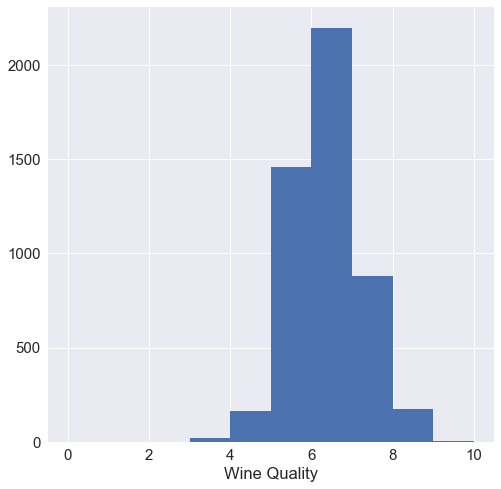

In [53]:
plt.figure(figsize=(8, 8))
plt.hist(df['quality'], range=(0, 10))
plt.xlabel('Wine Quality')
plt.show()

Most of the red wine samples provided fall between 5 and 7; meaning that they are mostly good wine (not excellent). This could affect the strength of prediction of the model since it will learn more of what makes red wine good.

Studying the correlation between the features will give an idea of what features really affect wine quality positively or negatively.

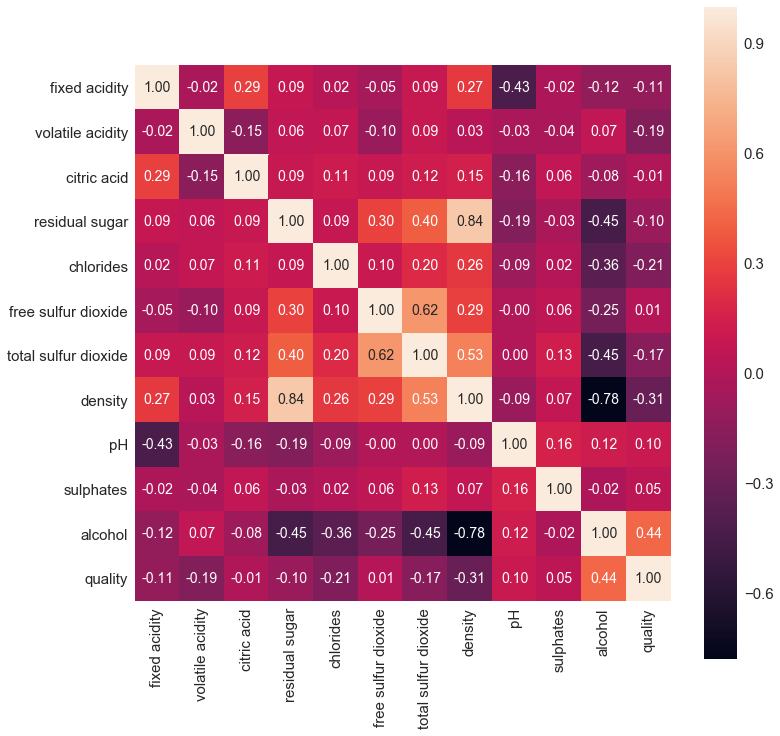

In [54]:
def heatmap(df):
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.5)
    sns.heatmap(df.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=df.columns, 
                xticklabels=df.columns)
    plt.show()
    
heatmap(df)

We will exam features with strong correlation (>=0.43) between them.

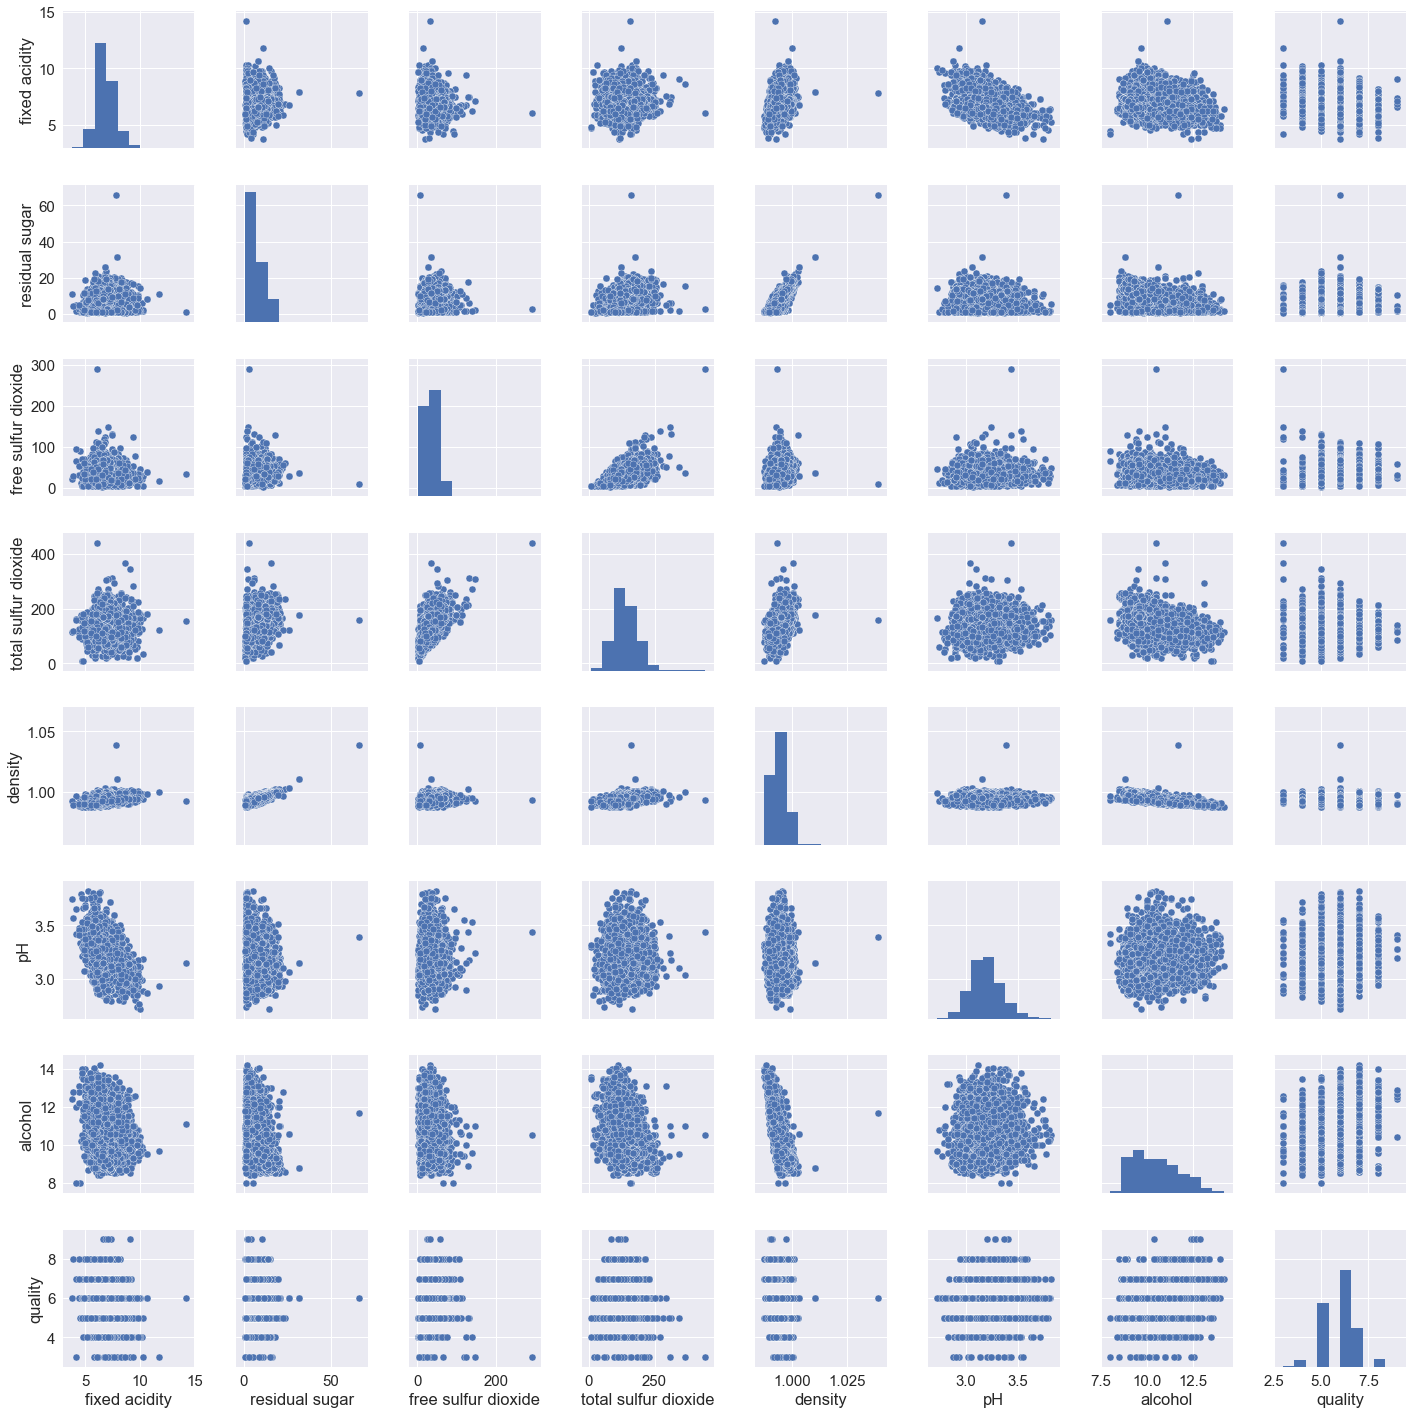

In [55]:
corr_cols = ['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 
             'alcohol', 'quality']

def pairplot(cols):
    sns.pairplot(df[cols])
    plt.show()
    
pairplot(corr_cols)

# Looking out for outliers #

The approach to be applied to looking for outliers will be to compare correlations between features and view the plot of points between these correlations. Correlation values greater than 0.5 and have "eye-balled" outliers from the pairplot will be analyzed.

In [56]:
from scipy import stats
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyfit
import random

def plot_relationship_best_fit(x_axis, x_label, y_axis, y_label, best_fit='linear'):
    fit = None
    
    if best_fit == 'linear':
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
        fit = slope * x_axis + intercept
#         c = polyfit(x_axis, y_axis, 1)
#         fit = c[0] + c[1]*x_axis
    
    if best_fit == 'quadratic':
        popt, pcov = curve_fit(func, x_axis, y_axis)
        fit = func(x_axis, *popt)
        
#         coef = polyfit(x_axis, y_axis, 2)
#         fit = coef[0] + coef[1]*x_axis + coef[2]*(x_axis**2)
        
    np.random.seed(42)
    r = random.randint(0, len(x_axis)-1)
    
    plt.figure(figsize=(8,8))    
    plt.scatter(x_axis, y_axis)
    plt.plot(x_axis, fit, color='r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [57]:
def corr_plot(x_axis, x_label, y_axis, y_label, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_axis, y_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

#### Residual Sugar & Density ####

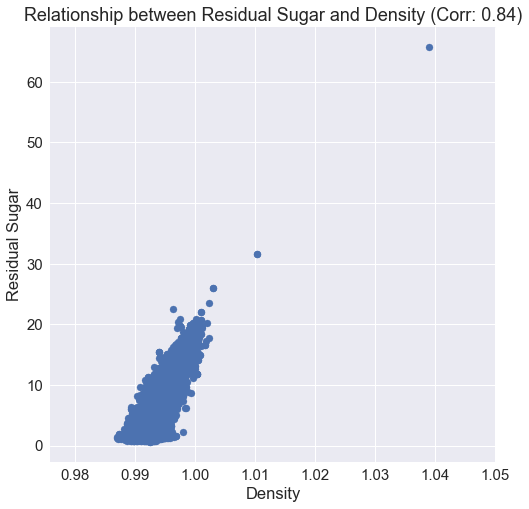

In [58]:
corr = 'Corr: %.2f' % df['residual sugar'].corr(df['density'])
corr_plot(df['density'], 'Density', df['residual sugar'], 'Residual Sugar', 
          'Relationship between Residual Sugar and Density ({})'.format(corr))

Residual sugar and density are highly positively correlated, therefore, there is no need to remove outliers.

#### Total Sulfur Dioxide & Density ####

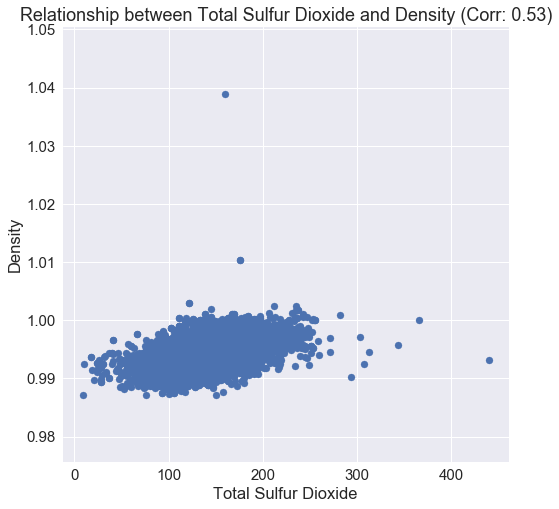

In [59]:
corr = 'Corr: %.2f' % df['total sulfur dioxide'].corr(df['density'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density', 
          'Relationship between Total Sulfur Dioxide and Density ({})'.format(corr))

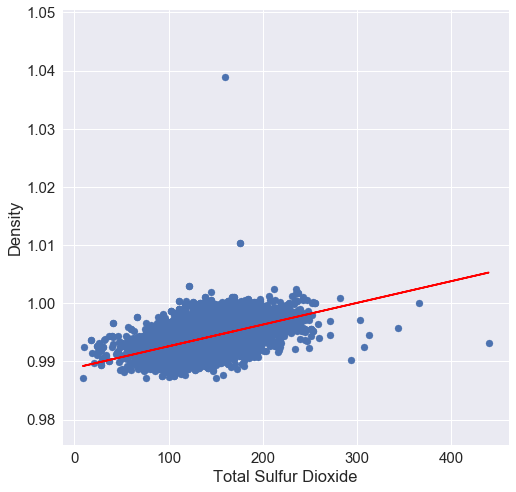

In [60]:
plot_relationship_best_fit(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density')

Total sulfur dioxide and density are positively correlated. Outliers can easily be "eyeballed". Density above 1.01 are too extreme cases that need to be removed. Total sulfur dioxide cases more than 300 will also be removed.

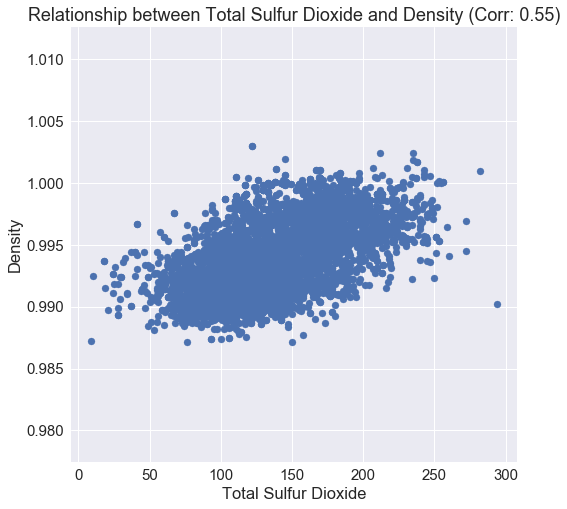

In [61]:
df = df[df['density'] < 1.01]
df = df[df['total sulfur dioxide'] < 300]

corr = 'Corr: %.2f' % df['total sulfur dioxide'].corr(df['density'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['density'], 'Density', 
          'Relationship between Total Sulfur Dioxide and Density ({})'.format(corr))

#### Density & Alcohol ####

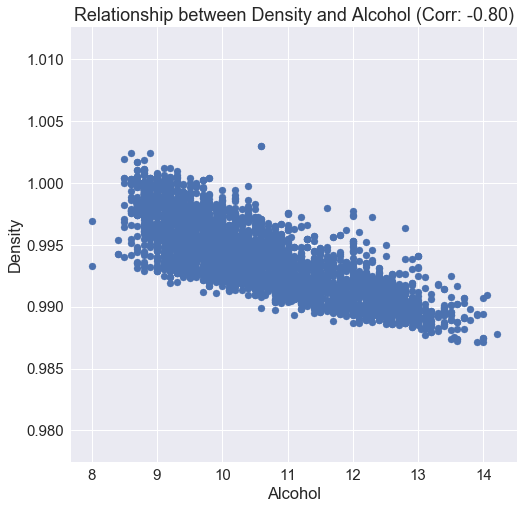

In [62]:
corr = 'Corr: %.2f' % df['density'].corr(df['alcohol'])
corr_plot(df['alcohol'], 'Alcohol', df['density'], 'Density', 
          'Relationship between Density and Alcohol ({})'.format(corr))

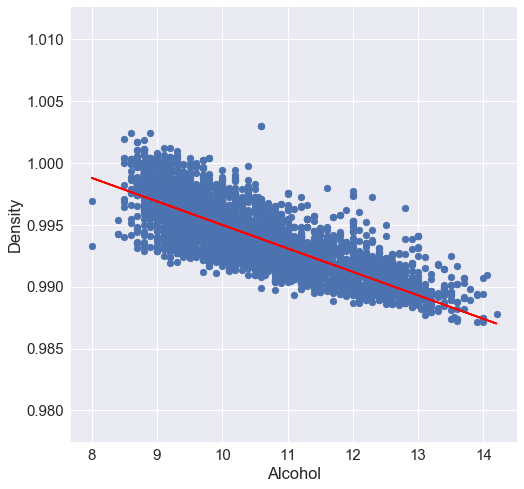

In [63]:
plot_relationship_best_fit(df['alcohol'], 'Alcohol', df['density'], 'Density')

#### Free Sulfur Dioxide & Total Sulfur Dioxide ####

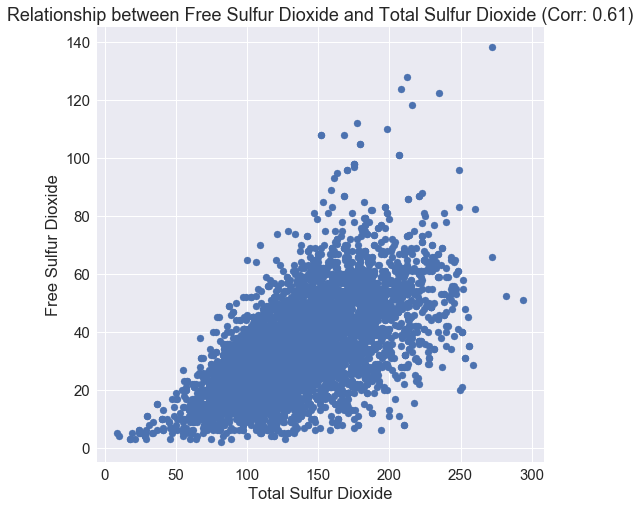

In [64]:
corr = 'Corr: %.2f' % df['free sulfur dioxide'].corr(df['total sulfur dioxide'])
corr_plot(df['total sulfur dioxide'], 'Total Sulfur Dioxide', df['free sulfur dioxide'], 'Free Sulfur Dioxide', 
          'Relationship between Free Sulfur Dioxide and Total Sulfur Dioxide ({})'.format(corr))

Free sulfur dioxide and total sulfur dioxide are positively correlated and the plot can be used as is without removing outliers.

In [65]:
df.shape

(4889, 12)

# Feature Engineering #

Features will be engineered to create new features based on the relationship between the features and their correlation. From research, total acidity is made up of fixed acidity and volatile acidity. These features will be combined to one feature. Features that have a correlation greater than 0.4 will be combined to form new features.

In [66]:
df['total acidity'] = df['fixed acidity'] + df['volatile acidity']
df['alcohol density'] = df['alcohol'] * df['density']
df['residual sugar density'] = df['residual sugar'] * df['density']
df['total sulfur dioxide density'] = df['total sulfur dioxide'] * df['density']
df['sulfur dioxide content'] = df['total sulfur dioxide'] * df['free sulfur dioxide']
df['alcohol quality'] = df['alcohol'] * df['quality']

df.drop(['alcohol', 'density', 'fixed acidity', 'volatile acidity', 'total sulfur dioxide', 
         'free sulfur dioxide'], axis=1, inplace=True)

df = df.reset_index(drop=True)

In [67]:
from sklearn.preprocessing import PolynomialFeatures

random_state = 42
target = df['quality']
features = df.drop('quality', axis=1)

# poly = PolynomialFeatures(2)
# features = poly.fit_transform(features)
features.shape

(4889, 11)

In [69]:
df.shape

(4889, 12)

# Feature Scaling #

With outliers removed, the dataset will be scaled using the `StandardScaler` class. But first the data will be split into training and testing sets with a ration of 70% to 30%.

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3422, 11)
(1467, 11)
(3422,)
(1467,)


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model #

The model will be trained using a neural network architecture and will be evaluated using the `r2 score`. The Keras library will be used in developing the neural network architecture, compiling, training, evaluating the model and predicting wine quality. The architecture is made up of the input layer, 8 hidden layer and the output/prediction layer. Dropout is applied to the hidden layers to avoid overfitting.

In [72]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(218))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(218))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                384       
_________________________________________________________________
activation_9 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 218)               7194      
_________________________________________________________________
dropout_8 (Dropout)          (None, 218)               0         
_________________________________________________________________
activation_10 (Activation)   (None, 218)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               112128    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
__________

Early stopping will be used to stop the training once there is no change in the loss. The training will stop if there is no change in loss after 250 iterations. Because of the size of the dataset, the test data will be used for validation. The model does not train on the test data.

In [73]:
early_stopping = EarlyStopping(patience=250)
history = model.fit(X_train, y_train, epochs=1000, verbose=1, validation_split=.3, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

Train on 3422 samples, validate on 1467 samples
Epoch 1/1000
3422/3422 [==============================] - 8s 2ms/step - loss: 48.5045 - mean_absolute_error: 2.4322 - acc: 0.1546 - val_loss: 8.2880 - val_mean_absolute_error: 2.7689 - val_acc: 0.0130
Epoch 2/1000
3422/3422 [==============================] - 8s 2ms/step - loss: 3.3998 - mean_absolute_error: 1.4699 - acc: 0.2189 - val_loss: 0.6999 - val_mean_absolute_error: 0.6796 - val_acc: 0.3899
Epoch 3/1000
3422/3422 [==============================] - 9s 3ms/step - loss: 1.3586 - mean_absolute_error: 0.9321 - acc: 0.3282 - val_loss: 1.1459 - val_mean_absolute_error: 0.9601 - val_acc: 0.1766
Epoch 4/1000
3422/3422 [==============================] - 8s 2ms/step - loss: 0.9561 - mean_absolute_error: 0.7549 - acc: 0.4267 - val_loss: 0.1227 - val_mean_absolute_error: 0.2647 - val_acc: 0.8630
Epoch 5/1000
3422/3422 [==============================] - 9s 2ms/step - loss: 0.7055 - mean_absolute_error: 0.6600 - acc: 0.4667 - val_loss: 0.3448 - v

Epoch 82/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0759 - mean_absolute_error: 0.2115 - acc: 0.9340 - val_loss: 0.0089 - val_mean_absolute_error: 0.0595 - val_acc: 0.9918
Epoch 83/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0762 - mean_absolute_error: 0.2141 - acc: 0.9299 - val_loss: 0.0139 - val_mean_absolute_error: 0.0729 - val_acc: 0.9864
Epoch 84/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0749 - mean_absolute_error: 0.2100 - acc: 0.9325 - val_loss: 0.0028 - val_mean_absolute_error: 0.0237 - val_acc: 0.9980
Epoch 85/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0734 - mean_absolute_error: 0.2107 - acc: 0.9395 - val_loss: 0.0113 - val_mean_absolute_error: 0.0534 - val_acc: 0.9864
Epoch 86/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0758 - mean_absolute_error: 0.2144 - acc: 0.9305 - val_loss: 0.0059 - val_mean_absolute_error: 0.0378 - val_ac

Epoch 161/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0387 - mean_absolute_error: 0.1500 - acc: 0.9828 - val_loss: 0.0015 - val_mean_absolute_error: 0.0185 - val_acc: 0.9993
Epoch 162/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0413 - mean_absolute_error: 0.1500 - acc: 0.9825 - val_loss: 0.0091 - val_mean_absolute_error: 0.0505 - val_acc: 0.9959
Epoch 163/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0397 - mean_absolute_error: 0.1502 - acc: 0.9828 - val_loss: 0.0059 - val_mean_absolute_error: 0.0483 - val_acc: 0.9973
Epoch 164/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0394 - mean_absolute_error: 0.1488 - acc: 0.9787 - val_loss: 0.0088 - val_mean_absolute_error: 0.0822 - val_acc: 0.9993
Epoch 165/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0367 - mean_absolute_error: 0.1464 - acc: 0.9839 - val_loss: 0.0032 - val_mean_absolute_error: 0.0262 - v

3422/3422 [==============================] - 10s 3ms/step - loss: 0.0234 - mean_absolute_error: 0.1051 - acc: 0.9901 - val_loss: 0.0029 - val_mean_absolute_error: 0.0184 - val_acc: 0.9966
Epoch 240/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0216 - mean_absolute_error: 0.1001 - acc: 0.9909 - val_loss: 0.0053 - val_mean_absolute_error: 0.0216 - val_acc: 0.9939
Epoch 241/1000
3422/3422 [==============================] - 12s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1006 - acc: 0.9939 - val_loss: 0.0017 - val_mean_absolute_error: 0.0147 - val_acc: 0.9986
Epoch 242/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0214 - mean_absolute_error: 0.1013 - acc: 0.9912 - val_loss: 0.0027 - val_mean_absolute_error: 0.0210 - val_acc: 0.9980
Epoch 243/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0220 - mean_absolute_error: 0.1018 - acc: 0.9915 - val_loss: 0.0024 - val_mean_absolute_error: 0.0295 - val_acc: 0.9993


3422/3422 [==============================] - 11s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0697 - acc: 0.9942 - val_loss: 0.0017 - val_mean_absolute_error: 0.0089 - val_acc: 0.9980
Epoch 319/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0700 - acc: 0.9921 - val_loss: 0.0028 - val_mean_absolute_error: 0.0269 - val_acc: 0.9980
Epoch 320/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0137 - mean_absolute_error: 0.0707 - acc: 0.9939 - val_loss: 8.7337e-04 - val_mean_absolute_error: 0.0198 - val_acc: 0.9993
Epoch 321/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0692 - acc: 0.9939 - val_loss: 0.0022 - val_mean_absolute_error: 0.0316 - val_acc: 0.9980
Epoch 322/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0167 - mean_absolute_error: 0.0739 - acc: 0.9895 - val_loss: 0.0028 - val_mean_absolute_error: 0.0241 - val_acc: 0.9

Epoch 358/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0576 - acc: 0.9927 - val_loss: 0.0038 - val_mean_absolute_error: 0.0232 - val_acc: 0.9980
Epoch 359/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0181 - mean_absolute_error: 0.0613 - acc: 0.9918 - val_loss: 0.0052 - val_mean_absolute_error: 0.0207 - val_acc: 0.9952
Epoch 360/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0156 - mean_absolute_error: 0.0586 - acc: 0.9904 - val_loss: 0.0036 - val_mean_absolute_error: 0.0227 - val_acc: 0.9973
Epoch 361/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0115 - mean_absolute_error: 0.0573 - acc: 0.9942 - val_loss: 0.0044 - val_mean_absolute_error: 0.0232 - val_acc: 0.9973
Epoch 362/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0546 - acc: 0.9939 - val_loss: 0.0027 - val_mean_absolute_error: 0.0172 - v

3422/3422 [==============================] - 10s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0562 - acc: 0.9936 - val_loss: 0.0032 - val_mean_absolute_error: 0.0454 - val_acc: 0.9993
Epoch 438/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0144 - mean_absolute_error: 0.0587 - acc: 0.9918 - val_loss: 0.0017 - val_mean_absolute_error: 0.0122 - val_acc: 0.9980
Epoch 439/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0585 - acc: 0.9930 - val_loss: 0.0014 - val_mean_absolute_error: 0.0187 - val_acc: 0.9993
Epoch 440/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0140 - mean_absolute_error: 0.0611 - acc: 0.9909 - val_loss: 0.0064 - val_mean_absolute_error: 0.0378 - val_acc: 0.9986
Epoch 441/1000
3422/3422 [==============================] - 11s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0595 - acc: 0.9915 - val_loss: 0.0023 - val_mean_absolute_error: 0.0339 - val_acc: 0.9993


3422/3422 [==============================] - 9s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0585 - acc: 0.9886 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280 - val_acc: 0.9966
Epoch 516/1000
3422/3422 [==============================] - 9s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0554 - acc: 0.9930 - val_loss: 0.0029 - val_mean_absolute_error: 0.0309 - val_acc: 0.9980
Epoch 517/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0115 - mean_absolute_error: 0.0557 - acc: 0.9933 - val_loss: 0.0030 - val_mean_absolute_error: 0.0251 - val_acc: 0.9980
Epoch 518/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0136 - mean_absolute_error: 0.0578 - acc: 0.9904 - val_loss: 0.0033 - val_mean_absolute_error: 0.0145 - val_acc: 0.9966
Epoch 519/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0565 - acc: 0.9915 - val_loss: 0.0029 - val_mean_absolute_error: 0.0165 - val_acc: 0.9973
Ep

3422/3422 [==============================] - 10s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0535 - acc: 0.9924 - val_loss: 0.0028 - val_mean_absolute_error: 0.0204 - val_acc: 0.9973
Epoch 596/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0549 - acc: 0.9912 - val_loss: 0.0039 - val_mean_absolute_error: 0.0397 - val_acc: 0.9980
Epoch 597/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0521 - acc: 0.9921 - val_loss: 0.0019 - val_mean_absolute_error: 0.0149 - val_acc: 0.9986
Epoch 598/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0175 - mean_absolute_error: 0.0548 - acc: 0.9918 - val_loss: 0.0020 - val_mean_absolute_error: 0.0189 - val_acc: 0.9986
Epoch 599/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0183 - mean_absolute_error: 0.0567 - acc: 0.9898 - val_loss: 0.0040 - val_mean_absolute_error: 0.0110 - val_acc: 0.9959


3422/3422 [==============================] - 10s 3ms/step - loss: 0.0177 - mean_absolute_error: 0.0543 - acc: 0.9904 - val_loss: 0.0036 - val_mean_absolute_error: 0.0139 - val_acc: 0.9966
Epoch 674/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0574 - acc: 0.9877 - val_loss: 0.0042 - val_mean_absolute_error: 0.0196 - val_acc: 0.9959
Epoch 675/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0184 - mean_absolute_error: 0.0600 - acc: 0.9868 - val_loss: 0.0064 - val_mean_absolute_error: 0.0393 - val_acc: 0.9945
Epoch 676/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0537 - acc: 0.9901 - val_loss: 0.0068 - val_mean_absolute_error: 0.0300 - val_acc: 0.9932
Epoch 677/1000
3422/3422 [==============================] - 10s 3ms/step - loss: 0.0174 - mean_absolute_error: 0.0579 - acc: 0.9871 - val_loss: 0.0070 - val_mean_absolute_error: 0.0326 - val_acc: 0.9939


# Visualize Training Errors #

In [74]:
def plot_error(train_errors, val_errors, xlabel, ylabel, title=None, legend=None):
    plt.figure(figsize=(8, 8))
    plt.plot(train_errors)
    plt.plot(val_errors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(legend, loc='best')
    plt.show()

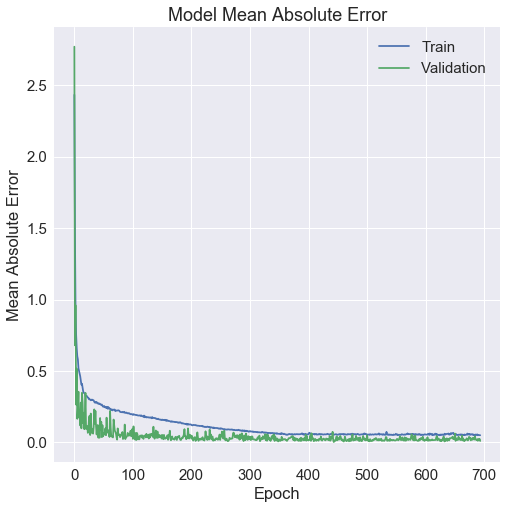

In [75]:
# Plot training & validation mean absolute values
plot_error(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'Epoch', 
           'Mean Absolute Error', 'Model Mean Absolute Error', ['Train', 'Validation'])

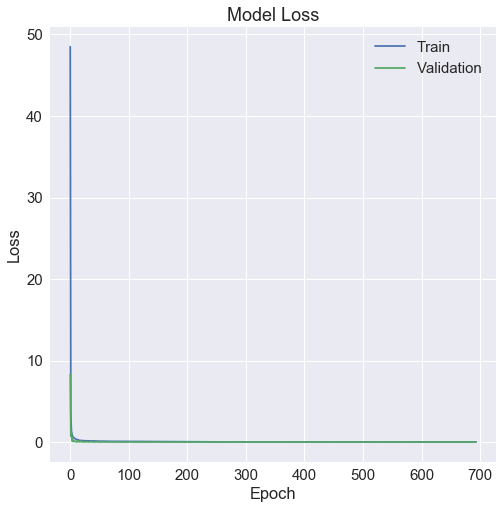

In [76]:
# Plot training & validation loss values
plot_error(history.history['loss'], history.history['val_loss'], 'Epoch', 'Loss', 'Model Loss', ['Train', 'Validation'])

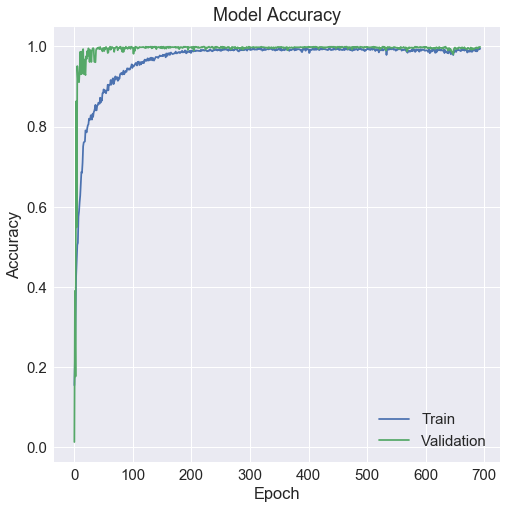

In [77]:
# Plot training & validation accuracy values
plot_error(history.history['acc'], history.history['val_acc'], 'Epoch', 'Accuracy', 'Model Accuracy', ['Train', 'Validation'])

# Make predictions #

Predictions will be rounded to their nearest units so as to easily compare with the test dataset's wine quality. The neural network predictions are returned as an array of arrays. These will be reshaped to a 1D array of predictions so that they can be compared with their ground-truth values (`y_test`).

In [78]:
predictions = model.predict(X_test)
predictions = np.reshape(predictions, predictions.shape[0])
predictions = np.round(predictions)

# Evaluate the model #

In [79]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, np.round(predictions))
print('R2 Score: %.3f' % r2)

R2 Score: 0.998


The plot below compares the predictions of the model with the corresponding ground-truth values.

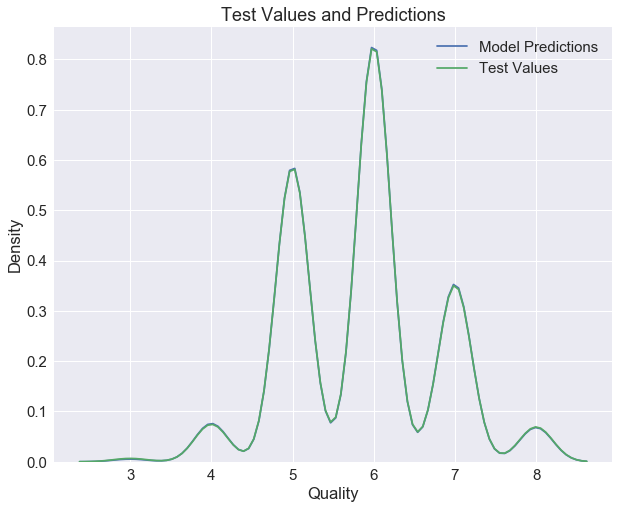

In [80]:
def evaluation_plot(y_test, predictions):
    plt.figure(figsize=(10, 8))

    # Density plot of the final predictions and the test values
    sns.kdeplot(predictions, label='Model Predictions')
    sns.kdeplot(y_test, label='Test Values')

    # Label the plot
    plt.xlabel('Quality')
    plt.ylabel('Density')
    plt.title('Test Values and Predictions')
    plt.show()

evaluation_plot(y_test, np.round(predictions))